In [1]:
import os
#Insert paths to Flow Loop data and Lablog_processed
PATH_DATA=os.path.join("..","data","raw","Rockwell_Flow_Loop_Data")
PATH_LABLOG=os.path.join("..","data","raw","Lablog_processed.xlsx")
#Insert month and day with the same format as this example
month,day="07","28"
#

In [2]:
#Be aware that this notebook uses the modules:
#     low_loop_preprocess_XW
#and  lablog_parser
#(see the last 4 lines of this cell)
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')
from datetime import timedelta
from datetime import datetime

import flow_loop_preprocess_XW as process
import sys
sys.path.append(os.path.join("..",".."))
import helpers.lablog_parser as lablog

In [3]:
#Read data and first preprocessing
data = pd.read_csv(os.path.join(PATH_DATA,"Flow_Loop_Data_"+month+day+"22.csv"))

data=process.table_formattting(data)
data.head()
for col in data:
    if data[col].dtype == 'O':
        data[col] = pd.to_datetime(data[col])

,time_Loop 1 Flow,Loop 1 Flow,time_Loop 1 Flow Raw Value,Loop 1 Flow Raw Value,time_Loop 2 Flow,Loop 2 Flow,time_Loop 2 Flow Raw Value,Loop 2 Flow Raw Value,time_Tank 1 Level,Tank 1 Level,...,time_Pump 2 Outlet Pressure Raw Value,Pump 2 Outlet Pressure Raw Value,time_Pump 1 Speed Feedback,Pump 1 Speed Feedback,time_Pump 1 Speed Feedback Raw Value,Pump 1 Speed Feedback Raw Value,time_Pump 2 Speed Feedback,Pump 2 Speed Feedback,time_Pump 2 Speed Feedback Raw Value,Pump 2 Speed Feedback Raw Value
0,2022-07-28 12:17:13,-0.028125,2022-07-28 08:00:14,3997.0,2022-07-28 12:17:12,-0.053750,2022-07-28 08:00:02,3966.0,2022-07-28 12:17:18,33.541000,...,2022-07-28 08:00:01,4133.0,2022-07-28 12:17:05,0.000000,2022-07-28 08:00:01,4000.0,2022-07-28 12:17:10,-0.007500,2022-07-28 08:00:04,3997.0
1,2022-07-28 12:17:19,1.312500,2022-07-28 08:00:37,3996.0,2022-07-28 12:17:13,20.000000,2022-07-28 08:00:02,3968.0,2022-07-28 12:17:36,32.933250,...,2022-07-28 08:00:02,4132.0,2022-07-28 12:17:07,1.492500,2022-07-28 08:00:04,4001.0,2022-07-28 12:17:10,0.517500,2022-07-28 08:00:05,3998.0
2,2022-07-28 12:17:20,5.634375,2022-07-28 08:00:37,3997.0,2022-07-28 12:17:13,0.095000,2022-07-28 08:00:06,3966.0,2022-07-28 12:33:11,32.559250,...,2022-07-28 08:00:02,4133.0,2022-07-28 12:17:09,16.575001,2022-07-28 08:00:05,4000.0,2022-07-28 12:17:13,15.581250,2022-07-28 08:00:05,3997.0
3,2022-07-28 12:17:22,8.812500,2022-07-28 08:00:43,3996.0,2022-07-28 12:17:14,5.696250,2022-07-28 08:00:07,3967.0,2022-07-28 13:29:43,32.376503,...,2022-07-28 08:00:03,4132.0,2022-07-28 12:17:19,26.126251,2022-07-28 08:00:06,4001.0,2022-07-28 12:17:14,17.201250,2022-07-28 08:00:06,3998.0
4,2022-07-28 12:17:25,9.365625,2022-07-28 08:00:44,3997.0,2022-07-28 12:17:14,6.772501,2022-07-28 08:00:08,3966.0,2022-07-28 13:31:56,32.240501,...,2022-07-28 08:00:04,4133.0,2022-07-28 12:17:21,23.415001,2022-07-28 08:00:06,4000.0,2022-07-28 12:17:15,14.816251,2022-07-28 08:00:09,3997.0


In [5]:
#Upsampling to 10s intervals
i = 0
while i <= (data.shape[1] - 2):
    sub_df = process.pull_feature(i, i+1, data)
    sub_df = sub_df.resample('10S').mean()
    if i == 0:
        df = sub_df
    else:
        df = df.join(sub_df, how='outer')
    i += 2
df = df.loc[:, df.columns.str.contains('Raw')]
#df

In [13]:
#anomaly plots
def anomalie_detection(event):#begin, end, event_name):
    #event_begin = pd.to_datetime('2022-'+month+'-'+day+' ' + begin.strftime("%H:%M:%S"))
    #event_end = pd.to_datetime('2022-'+month+'-'+day+' ' + end.strftime("%H:%M:%S"))
    event_name = event[0]
    event_begin = event[1]
    event_end = event[2]
    pre_time = event_begin - timedelta(minutes=2)
    aft_time = event_end + timedelta(minutes=3)

    sub_df = df[pre_time : aft_time]
    fig, ax = plt.subplots(figsize=(18,8))
    ax.plot(sub_df,'o-', label=df.columns)
    ax.vlines([event_begin, event_end], 3900, 18000, colors='black', linestyles='dashed' )
    ax.set_yscale('log')
    ax.legend()
    ax.set_title(f'{event_name}, begin: {event_begin}, end: {event_end}', fontsize=14)
    plt.show()

In [14]:
events = lablog.read_anomalies(PATH_LABLOG,['2022-'+month+'-'+day])
#events

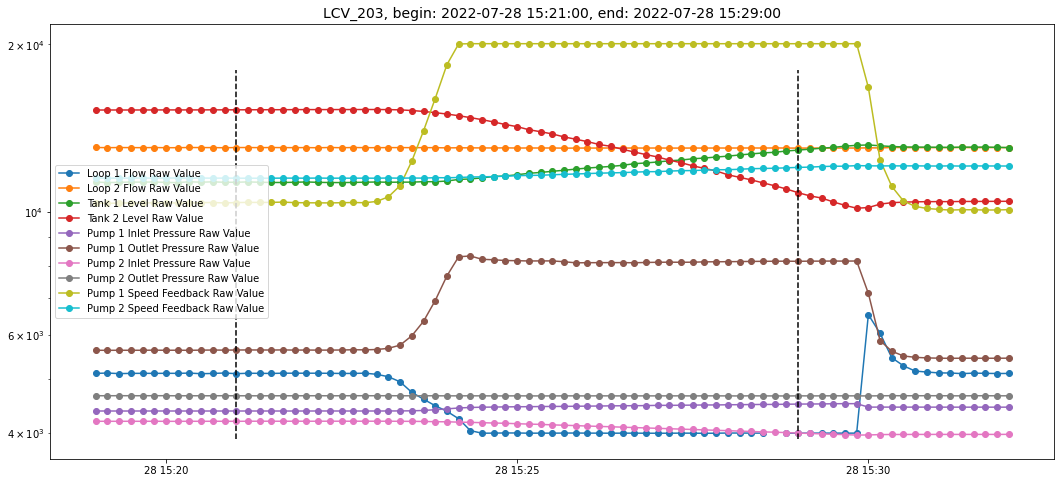

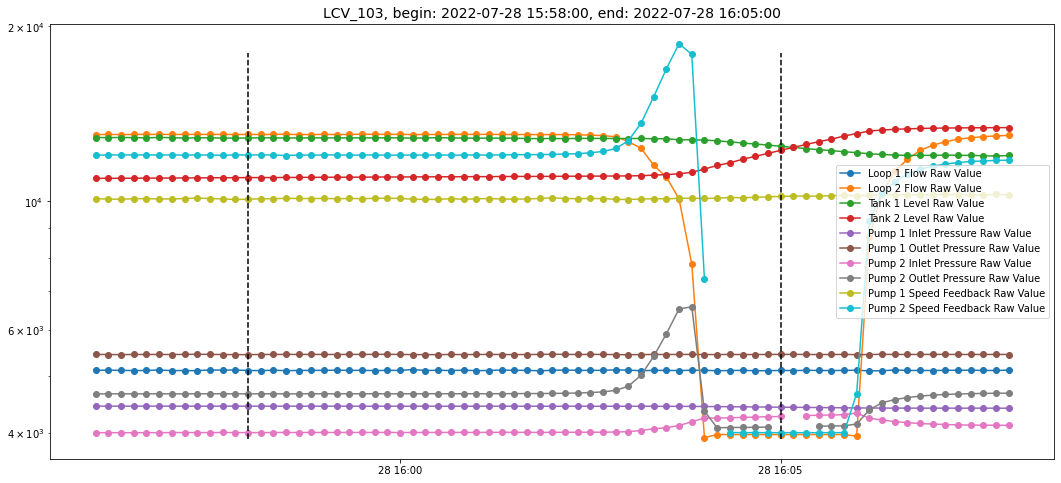

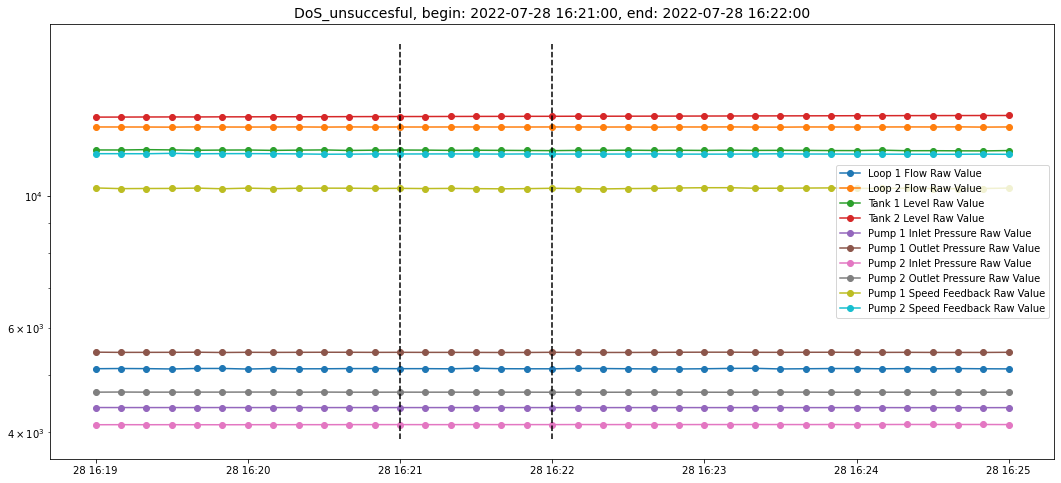

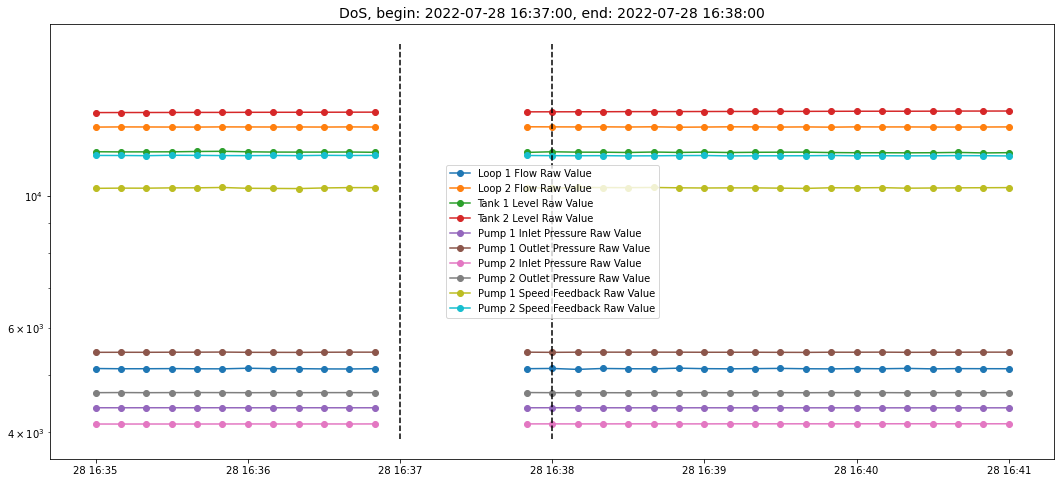

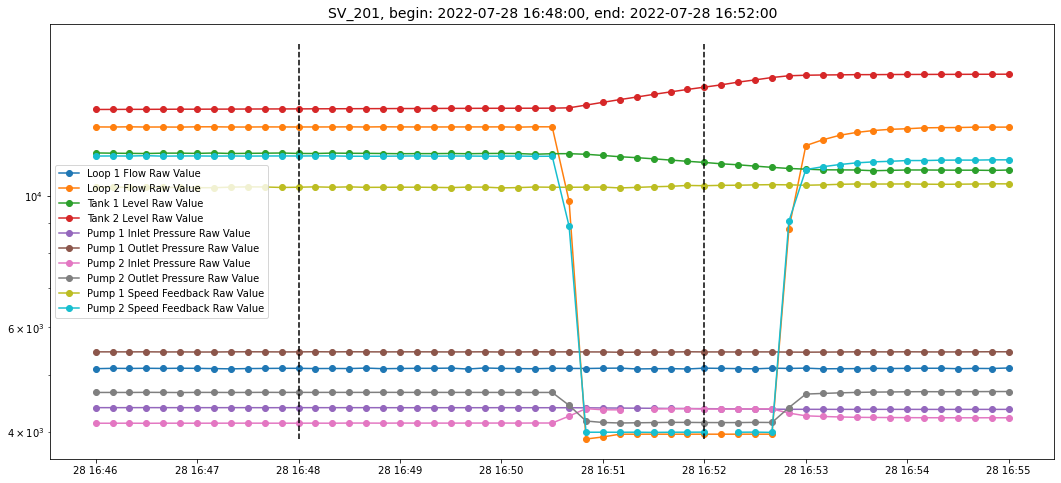

In [15]:
for event in events:
    anomalie_detection(event)#[1], event[2], event[0])